# Week 12: U-Net
## Convolutional Networks for Image Segmentation

Olaf Ronneberger, Philipp Fischer, and Thomas Brox
2015

U-Net is a segmentation network whose architecture resembles the letter "u". The network "contracts to capture context and a symmetric expanding path that enables precise localization" (Ronnenberger et al. 2015).


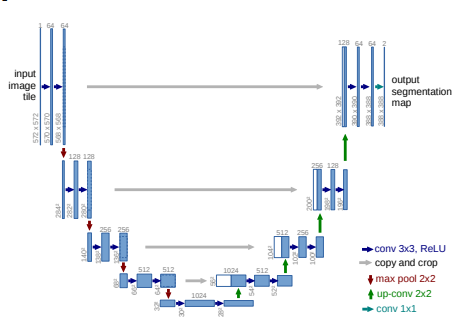














The example provided here will use a dataset of images we chose to use is labeled to classify cars. There are two labels in these images ('car' and 'not car'). 


In [1]:
import torch
from torch import nn
from torch import optim
import torch.utils.data as data_utils
from torchvision import transforms
import torchvision.transforms.functional as TF

import numpy as np
import os
from PIL import Image 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

def data_loader():
  # Specify the directories for the input data X and teh target images y
  X_dir = "data/images/"
  y_dir = "data/masks/"
  
  # Fetch images using pillow, convert to tensors, and stack in torch tensor
  X = torch.stack([transforms.PILToTensor()(Image.open(X_dir+f)) for f in os.listdir(X_dir)])
  y = torch.stack([transforms.PILToTensor()(Image.open(y_dir+f)) for f in os.listdir(y_dir)])
  
  # Return X and y (the masks) as a tensor of 0 and 1 values
  #   The reason for this is that y is fromm 0 to 255 so we need
  #   to convert this to binary values (0 or 1, car or background)
  return X,(y>50).long()


imgs,labels = data_loader()

# Split the data into train and test sets
imgs_train, imgs_test, labels_train, labels_test = train_test_split(
    imgs, labels, test_size=0.2, random_state=1
)


C:\Users\Gina\AppData\Local\Temp/ipykernel_133648/3895060005.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


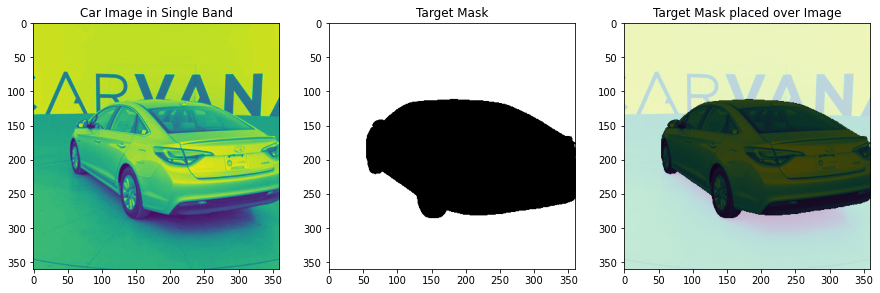

In [2]:
# Fetch random image and mask
idx = np.random.randint(0, np.shape(imgs))[0]
single_digit = imgs[idx]
single_label = labels[idx]

# Display the image, the mask, and a combination of the two
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,15))

ax1.title.set_text('Car Image in Single Band')
ax1.imshow(single_digit.squeeze(), )
ax2.title.set_text('Target Mask')
ax2.imshow(single_label.squeeze(), cmap="Greys")
ax3.title.set_text('Target Mask placed over Image')
ax3.imshow(single_digit.squeeze(), )
ax3.imshow(single_label.squeeze(), cmap="Greys",  alpha=0.7)

fig.show()

In [3]:
# Check for GPU capability
is_cuda = torch.cuda.is_available()

if is_cuda:
  device = torch.device("cuda") # GPU
else:
  device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches” and reshuffle the data at every epoch to reduce model overfitting. 

In [4]:
# The batch size for training
batch_size = 1

# A lambda function to prepare tensors for the GPU capability in the dataloaders
to_device = lambda a: a.to(device)

# Create data loaders for train and test datasets
train_loader = data_utils.DataLoader(
  data_utils.TensorDataset(to_device(imgs_train), to_device(labels_train)),
  batch_size = batch_size,
  shuffle = True
)

test_loader = data_utils.DataLoader(
  data_utils.TensorDataset(to_device(imgs_test), to_device(labels_test)),
  batch_size = batch_size,
  shuffle = True
)


In [5]:

# This double convolution operation is repeated through the network, 
# so package it for repeated use:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)



In [6]:

# Define the U-Net architecture as a sub-class of torch.nn.Module
class UNET(nn.Module):
  def __init__(
    self, 
    in_channels=1, # number of channels in the input
    out_channels=2, # number of channels in the output
    features=[64, 128, 256, 512] # number of features at each layer in the network
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()  # operations in the contracting path
    self.downs = nn.ModuleList()  # operations in the expanding path
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # the max pooling operation

    # Contracting part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Expanding part of UNET
    for feature in reversed(features):
      self.ups.append(
        nn.ConvTranspose2d(
          feature*2, feature, kernel_size=2, stride=2,
        )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    # Define the bottom of the network and the final convolution
    self.network_bottom = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    # Iterate through the contracting convolutions and max-pooling
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    # Go through the bottom of the network
    x = self.network_bottom(x)
    # Reverse the order of skip connections
    skip_connections = skip_connections[::-1]

    # Iterate through the expanding portion of the network
    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      # Add the skip connection data from the contracting path
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    # Perform the final convolution to 2 classes
    x = self.final_conv(x)
    # Perform softmax
    x = nn.Softmax(dim=1)(x)
    # Return the max value so the output image is labeled (0,1) like the target label images
    return torch.argmax(x, dim=1) 

In [7]:
# Functions for training a model...
def train_model(
  model, 
  train_data, 
  test_data, 
  optimizer, 
  error_func, 
  n_epochs, 
  augment_method=None, 
  print_every=1
):
  for epoch_i in range(1, n_epochs + 1):
    for i, (img, label) in enumerate(train_data, 1):
      model.zero_grad()
      predicted = model.forward(img.float())
      loss = error_func(predicted.float().requires_grad_(), label[0].to(torch.float))
      loss.backward()
      optimizer.step()
      
      if((i % print_every == 0) or (i == len(train_data))):
        print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
            
    # Run against the test set and train set at the end of each epoch to get accuracy...
    acc1 = get_accuracy(model, train_data, augment_method)
    print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
    acc2 = get_accuracy(model, test_data, augment_method)
    print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
  
  return model


def get_accuracy(model, data, im_mod = None):
  run = 0
  correct = 0

  for count, (img, label) in enumerate(data, 1):
    run += len(img)
    result = model.forward(img.float()).cpu().detach().numpy()
    correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
    print("Validation at {:.2f}%".format(count/len(data)*100.),end='\r')

  return correct / run

In [8]:
# Instantiate model
unet_model = UNET(in_channels=1, out_channels=2)

# Initialize model hyperparameters 
n_epochs = 2
lr = 1e-4
optimizer = optim.SGD(unet_model.parameters(), lr=lr, momentum=0.9)
loss_func = nn.BCEWithLogitsLoss()

In [9]:
# Train the model
res_net = train_model(unet_model, train_loader, test_loader, optimizer, loss_func, n_epochs)

Epoch: 1/2, Iter: 1/51, Loss: 0.6962
Epoch: 1/2, Iter: 2/51, Loss: 0.6957
Epoch: 1/2, Iter: 3/51, Loss: 0.6957
Epoch: 1/2, Iter: 4/51, Loss: 0.6957
Epoch: 1/2, Iter: 5/51, Loss: 0.6962
Epoch: 1/2, Iter: 6/51, Loss: 0.6959
Epoch: 1/2, Iter: 7/51, Loss: 0.6965
Epoch: 1/2, Iter: 8/51, Loss: 0.6961
Epoch: 1/2, Iter: 9/51, Loss: 0.6959
Epoch: 1/2, Iter: 10/51, Loss: 0.6959
Epoch: 1/2, Iter: 11/51, Loss: 0.6962
Epoch: 1/2, Iter: 12/51, Loss: 0.6960
Epoch: 1/2, Iter: 13/51, Loss: 0.6957
Epoch: 1/2, Iter: 14/51, Loss: 0.6961
Epoch: 1/2, Iter: 15/51, Loss: 0.6959
Epoch: 1/2, Iter: 16/51, Loss: 0.6964
Epoch: 1/2, Iter: 17/51, Loss: 0.6954
Epoch: 1/2, Iter: 18/51, Loss: 0.6958
Epoch: 1/2, Iter: 19/51, Loss: 0.6962
Epoch: 1/2, Iter: 20/51, Loss: 0.6956
Epoch: 1/2, Iter: 21/51, Loss: 0.6965
Epoch: 1/2, Iter: 22/51, Loss: 0.6964
Epoch: 1/2, Iter: 23/51, Loss: 0.6960
Epoch: 1/2, Iter: 24/51, Loss: 0.6956
Epoch: 1/2, Iter: 25/51, Loss: 0.6965
Epoch: 1/2, Iter: 26/51, Loss: 0.6963
Epoch: 1/2, Iter: 27/